In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from google.colab import drive
import random
from sklearn.metrics import accuracy_score
import time
import math
# import sys
np.set_printoptions(threshold=False) # for printing entire array after ohe
plt.style.use('ggplot')

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/COMP_551/A1/data2.txt', sep=",", header=None)
df.columns=['indus_risk','mgmt_risk', 'flexibility', 'credibility', 'competitiveness', 'oprt_risk', 'class']

In [ ]:
df

,indus_risk,mgmt_risk,flexibility,credibility,competitiveness,oprt_risk,class
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB
...,...,...,...,...,...,...,...
245,N,N,A,N,N,N,B
246,P,N,N,N,N,N,B
247,A,N,N,N,N,N,B
248,N,N,N,N,N,N,B


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   indus_risk       250 non-null    object
 1   mgmt_risk        250 non-null    object
 2   flexibility      250 non-null    object
 3   credibility      250 non-null    object
 4   competitiveness  250 non-null    object
 5   oprt_risk        250 non-null    object
 6   class            250 non-null    object
dtypes: object(7)
memory usage: 13.8+ KB


In [ ]:
df.describe()

,indus_risk,mgmt_risk,flexibility,credibility,competitiveness,oprt_risk,class
count,250,250,250,250,250,250,250
unique,3,3,3,3,3,3,2
top,N,N,N,N,N,N,NB
freq,89,119,119,94,103,114,143


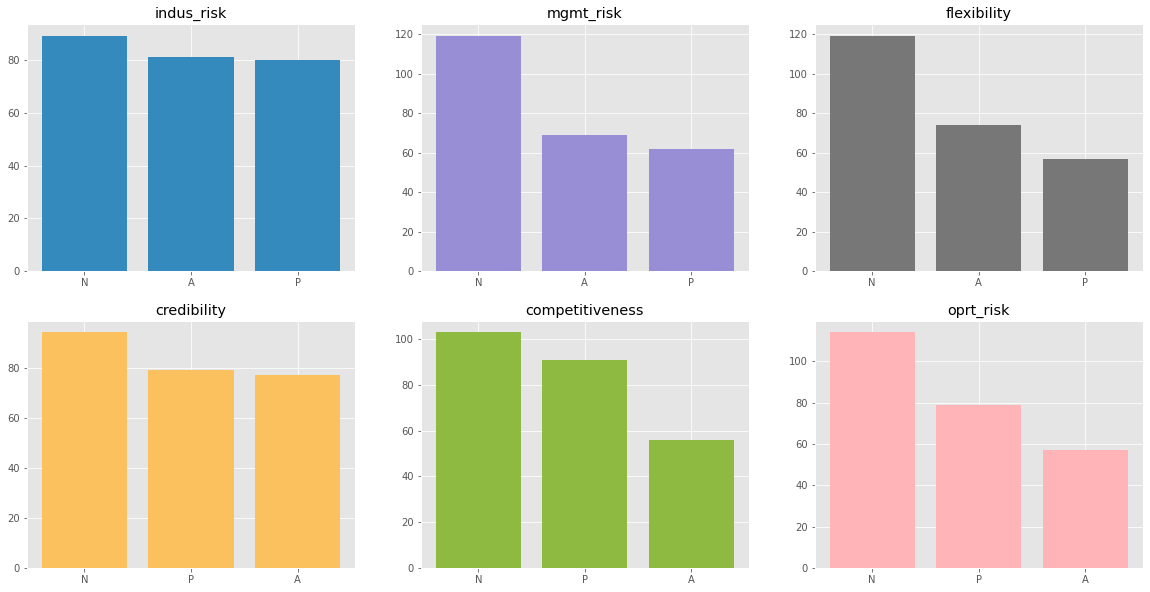

In [ ]:
# count plot for each input feature

feats=df.select_dtypes(include=object).columns
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
feat_count=0
for row in ax:
    for cell in row:
        feat=feats[feat_count]
        df_plot=pd.DataFrame(df[feat].value_counts())
        cell.bar(df_plot.index, df_plot[feat],  color=list(plt.rcParams['axes.prop_cycle'])[feat_count+1]['color'])
        cell.title.set_text(feat)
        feat_count+=1
plt.show()

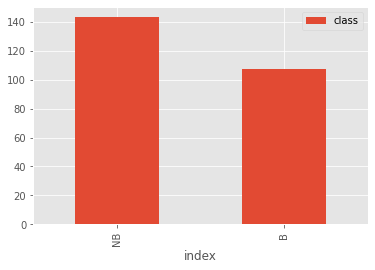

In [ ]:
df_class=pd.DataFrame(df['class'].value_counts()).reset_index()
df_class.plot('index', 'class', kind='bar')
plt.show()


In [ ]:
print(df)
print("___________")
X=df.iloc[:, :-1]
y=df.iloc[:, -1:]
print(X)
print("___________")
print(y)

    indus_risk mgmt_risk flexibility credibility competitiveness oprt_risk  \
0            P         P           A           A               A         P   
1            N         N           A           A               A         N   
2            A         A           A           A               A         A   
3            P         P           P           P               P         P   
4            N         N           P           P               P         N   
..         ...       ...         ...         ...             ...       ...   
245          N         N           A           N               N         N   
246          P         N           N           N               N         N   
247          A         N           N           N               N         N   
248          N         N           N           N               N         N   
249          P         N           N           N               A         A   

    class  
0      NB  
1      NB  
2      NB  
3      NB  
4  

In [ ]:
X

,indus_risk,mgmt_risk,flexibility,credibility,competitiveness,oprt_risk
0,P,P,A,A,A,P
1,N,N,A,A,A,N
2,A,A,A,A,A,A
3,P,P,P,P,P,P
4,N,N,P,P,P,N
...,...,...,...,...,...,...
245,N,N,A,N,N,N
246,P,N,N,N,N,N
247,A,N,N,N,N,N
248,N,N,N,N,N,N


In [ ]:
ohe = OneHotEncoder()
transformed_matrix = ohe.fit_transform(X).toarray()
transformed_matrix

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Implementing Logistic Regression

---



## Logistic Regression Class

---


In [ ]:
from pandas.core.indexes.range import NumericIndex
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.indices=[]
        self.costs=[]
        self.sum_of_gradient=0
        self.l2_reg=0
        self.w=0

    def logistic(self, z):
      return 1 / (1 + np.exp(-z))

    # Ask: this is an okay way to generate the batches, right?

    def batch_generator(self,x, y, size, indices):
      random_list=[]
      if len(indices)<size:
        random_list=indices
      else:
        random_list=random.sample(indices, size)
      indices = [ele for ele in indices if ele not in random_list]
      x_mini=x[random_list]
      y_mini=y[random_list]
      return x_mini, y_mini, indices

    def cost_fn(self, x, y, w):
        N, D = x.shape                                                       
        z = np.dot(x, w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
        return J

    def gradient(self, x, y, w): # define the gradient function                      
      yh =  x @ w
      N, D = x.shape
      x_transpose=np.transpose(x)
      delta_y=yh - y
      grad = 1/N*(x_transpose @ (delta_y)) + self.l2_reg*self.w 
      
      return (grad)

    def fit(self, x, y, learning_rate=0.1, batch_size=25, decay_rate=0, l2_reg=0):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        number_of_batches=N//batch_size
        self.learning_rate=learning_rate
        self.l2_reg=l2_reg # setting the regularization parameter
        self.w = np.zeros(D)
        g = np.inf 
        t = 1
        temp_all_indices=[x for x in range(N)]
        self.indices = temp_all_indices # setting list of indices

        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if len(self.indices)==0:
              self.indices=temp_all_indices 

            x_mini, y_mini, new_indices = self.batch_generator(x, y, batch_size, self.indices)
            self.indices=new_indices
            g = self.gradient(x_mini, y_mini, self.w)
            self.sum_of_gradient=g+self.sum_of_gradient*decay_rate # update running sum
            self.w = self.w - learning_rate * self.sum_of_gradient         # weight update step
            
            # cost would have to be appended after each update
            # print(t)
            # print(f"N: {N}")
            # print(f"batch_size: {batch_size}")
            # print(f"Number of batches: {number_of_batches}")
            # print(N//batch_size)
            if t%(number_of_batches)==0:
              cost_val = (self.cost_fn(w=self.w,y=y_mini,x=x_mini))
              self.costs.append(cost_val)
            
            t += 1
        return self.w, self.costs
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x,self.w))            #predict output

        #Converting values to their appropriate upper or lower value
        filter_arr = []
        for el in yh:
          if(el <0.5):
            filter_arr.append(0)
          else:
            filter_arr.append(1)
        return filter_arr

##initial run

In [ ]:
x = transformed_matrix
y = df['class'].apply(lambda x: 1 if x == 'B' else 0).values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
model=LogisticRegression()
weights=model.fit(x=X_train, y=y_train,learning_rate=0.01,batch_size=8)
y_predict=model.predict(X_test)
#convert the NDArray to a regular python array of int
test_arr = []
for el in y_test:
  if(el <0.5):
    test_arr.append(0)
  else:
    test_arr.append(1)
print('Filter Arrays accuracy:', accuracy_score(test_arr, y_predict))

Filter Arrays accuracy: 0.7590361445783133


In [ ]:
#indus_risk	mgmt_risk	flexibility	credibility	competitiveness	oprt_risk
feats=['indus_risk_A',
       'indus_risk_P',
       'indus_risk_N',
 'mgmt_risk_A', 'mgmt_risk_P', 'mgmt_risk_N',
 'flexibility_A', 'flexibility_P', 'flexibility_N',
 'credibility_A', 'credibility_P', 'credibility_N',
 'competitiveness_A', 'competitiveness_B', 'competitiveness_N',
 'oprt_risk_A', 'oprt_risk_B', 'oprt_risk_N',
'bias'
 ]
data = {'feature': feats, 'weights': weights[0]}
weights_df=pd.DataFrame.from_dict(data)
weights_df

,feature,weights
0,indus_risk_A,-0.002827
1,indus_risk_P,0.049576
2,indus_risk_N,0.072363
3,mgmt_risk_A,0.028858
4,mgmt_risk_P,0.058598
5,mgmt_risk_N,0.031655
6,flexibility_A,-0.008232
7,flexibility_P,0.137553
8,flexibility_N,-0.010210
9,credibility_A,0.002602


In [ ]:
# print(len(weights[0]))

In [ ]:
250//250

1

##Varying training data size

For training size of 20.0%, the training accuracy is 0.64 and the test accuracy is 0.78
For training size of 30.0%, the training accuracy is 0.6666666666666666 and the test accuracy is 0.7714285714285715
For training size of 40.0%, the training accuracy is 0.67 and the test accuracy is 0.7333333333333333
For training size of 50.0%, the training accuracy is 0.688 and the test accuracy is 0.712
For training size of 60.0%, the training accuracy is 0.7066666666666667 and the test accuracy is 0.77
For training size of 70.0%, the training accuracy is 0.6971428571428572 and the test accuracy is 0.7333333333333333
For training size of 80.0%, the training accuracy is 0.705 and the test accuracy is 0.72


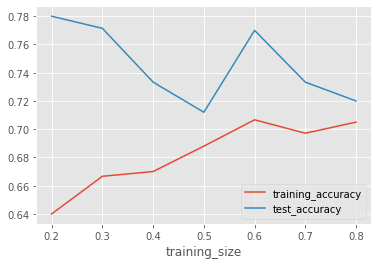

,training_size,training_accuracy,test_accuracy
0,0.2,0.640000,0.780000
1,0.3,0.666667,0.771429
2,0.4,0.670000,0.733333
3,0.5,0.688000,0.712000
4,0.6,0.706667,0.770000
5,0.7,0.697143,0.733333
6,0.8,0.705000,0.720000


In [ ]:
# Test error, and train error with varying training data size

training_size=[0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]
train_error_list=[]
test_error_list=[]
x = transformed_matrix
y = df['class'].apply(lambda x: 1 if x == 'B' else 0).values
for size in training_size:
  X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=size, random_state=42)
  model=LogisticRegression()
  weights=(model.fit(x=X_train, y=y_train, batch_size=len(X_train)))[0]
  y_predict_test=model.predict(X_test)
  test_error=accuracy_score(y_test, y_predict_test)
  y_predict_train=model.predict(X_train)
  train_error=accuracy_score(y_train, y_predict_train)
  print(f"For training size of {size*100}%, the training accuracy is {train_error} and the test accuracy is {test_error}")
  train_error_list.append(train_error)
  test_error_list.append(test_error)

data = {'training_size': training_size, 'training_accuracy': train_error_list, 'test_accuracy': test_error_list}
varied_training_size_df=pd.DataFrame.from_dict(data)
varied_training_size_df.plot(x='training_size')
plt.show()
varied_training_size_df

##Stochastic mini-batch gradient descent with varying batch size

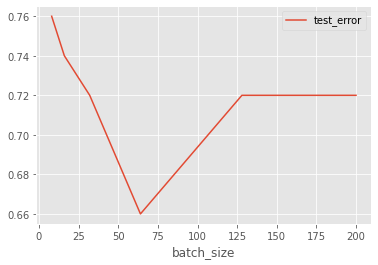

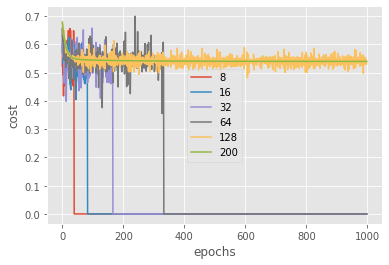

In [ ]:
# varying the batch size
batch_sizes=[8, 16, 32, 64, 128, int(250*0.8)]
error_list=[]
time_list=[]
x = transformed_matrix
y = df['class'].apply(lambda x: 1 if x == 'B' else 0).values
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=.80, random_state=42)

# error plots
for size in batch_sizes:
  model=LogisticRegression()
  weights=(model.fit(x=X_train, y=y_train,batch_size=size))[0]
  y_predict_test=model.predict(X_test)
  test_error=accuracy_score(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'batch_size': batch_sizes, 'test_error': error_list}
varied_batch_size_df=pd.DataFrame.from_dict(error_data)
varied_batch_size_df.plot(x='batch_size', y='test_error')
plt.show()

# convergence speed plots
all_costs={}
for size in batch_sizes: # change size
  model=LogisticRegression(max_iters=1000)
  fit_return_list=model.fit(x=X_train, y=y_train,batch_size=size) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(size)] = costs


max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))

for key in all_costs:
  all_costs[key] = all_costs[key]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

##Varying learning rates

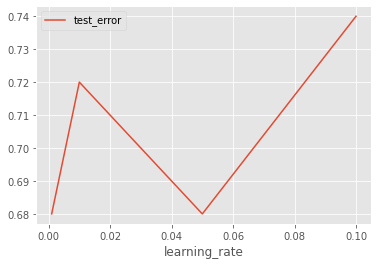

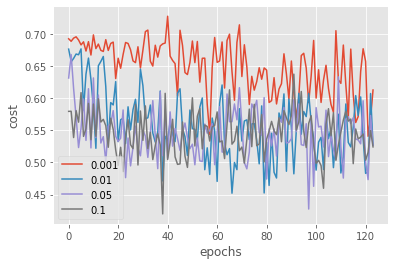

In [ ]:
# varying the learning rates

learning_rates=[0.001, 0.01, 0.05, 0.1] # change Maybe get rid of 0.12
error_list=[]
time_list=[]
x = transformed_matrix
y = df['class'].apply(lambda x: 1 if x == 'B' else 0).values
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=.80, random_state=42)

# error plots
for size in learning_rates:
  model=LogisticRegression()
  weights=(model.fit(x=X_train, y=y_train,learning_rate=size))[0]
  y_predict_test=model.predict(X_test)
  test_error=accuracy_score(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'learning_rate': learning_rates, 'test_error': error_list}
varied_batch_size_df=pd.DataFrame.from_dict(error_data)
varied_batch_size_df.plot(x='learning_rate', y='test_error')
plt.show()

# convergence speed plots
all_costs={}
for size in learning_rates: # change size
  model=LogisticRegression(max_iters=1000)
  fit_return_list=model.fit(x=X_train, y=y_train,learning_rate=size) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(size)] = costs

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))

for key in all_costs:
  all_costs[key] = all_costs[key]
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()


##Varying regularization parameter

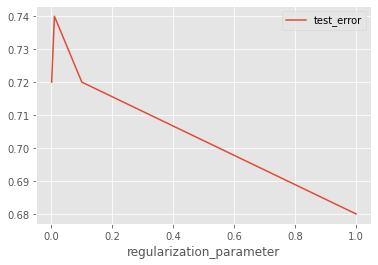

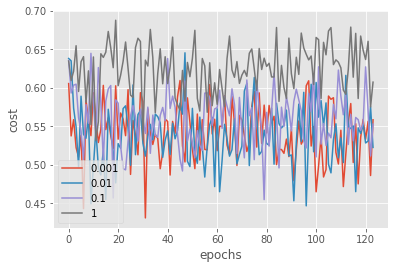

In [ ]:
# varying the reg parameter

regularization_parameters=[0.001, 0.01, 0.1, 1] # change
error_list=[]
time_list=[]
x = transformed_matrix
y = df['class'].apply(lambda x: 1 if x == 'B' else 0).values
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=.80, random_state=42)

# error plots
for rp in regularization_parameters:
  model=LogisticRegression()
  weights=(model.fit(x=X_train, y=y_train,learning_rate=size))[0]
  y_predict_test=model.predict(X_test)
  test_error=accuracy_score(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'regularization_parameter': regularization_parameters, 'test_error': error_list}
varied_batch_size_df=pd.DataFrame.from_dict(error_data)
varied_batch_size_df.plot(x='regularization_parameter', y='test_error')
plt.show()

# convergence speed plots
all_costs={}
for rp in regularization_parameters: # change size
  model=LogisticRegression(max_iters=1000)
  fit_return_list=model.fit(x=X_train, y=y_train, l2_reg=rp) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(rp)] = costs

max_len = max(len(value) for value in all_costs.values())
for key, value in all_costs.items():
    all_costs[key] = value + [0] * (max_len - len(value))
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

##Adding momentum and varying decay rate

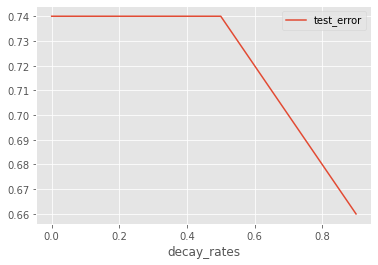

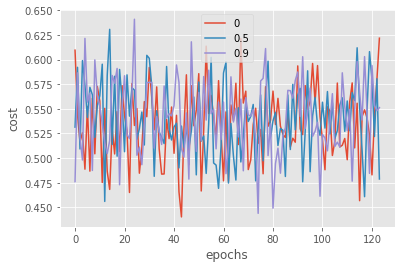

In [ ]:
# varying decay rate

decay_rates=[0, 0.5, 0.9] # change
error_list=[]
time_list=[]
x = transformed_matrix
y = df['class'].apply(lambda x: 1 if x == 'B' else 0).values
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=.80, random_state=42)

# error plots
for dr in decay_rates:
  model=LogisticRegression()
  weights=(model.fit(x=X_train, y=y_train,decay_rate=size))[0]
  y_predict_test=model.predict(X_test)
  test_error=accuracy_score(y_test, y_predict_test)
  error_list.append(test_error)
  
error_data = {'decay_rates': decay_rates, 'test_error': error_list}
varied_batch_size_df=pd.DataFrame.from_dict(error_data)
varied_batch_size_df.plot(x='decay_rates', y='test_error')
plt.show()

# convergence speed plots
all_costs={}
for dr in decay_rates: # change size
  model=LogisticRegression(max_iters=1000)
  fit_return_list=model.fit(x=X_train, y=y_train, decay_rate=dr) # change hyper-parameter
  costs=fit_return_list[1]
  all_costs[str(dr)] = costs

# max_len = max(len(value) for value in all_costs.values())
# for key, value in all_costs.items():
#     all_costs[key] = value + [0] * (max_len - len(value))
varied_df=pd.DataFrame.from_dict(all_costs)
varied_df.plot()
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()
